In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [37]:

def ORBfeatures(img1, img2):
    '''
    Code to get ORB point correspondences
    '''
#     orb = cv2.ORB_create(nfeatures = 500)
    orb = cv2.xfeatures2d.SIFT_create(nfeatures=500)
    
    
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    # brute force point matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
#     Draw first 10 matches.
#     img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches, None)
#     plt.imshow(img3)
#     plt.show()
    points_1 = np.empty((1,3))
    points_2 = np.empty((1,3))

    # print(points_1)
    for mat in matches:

        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # print(kp1[img1_idx].pt)
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt


        points_1 = np.vstack((points_1, np.array([[x1, y1, 1]])))
        points_2 = np.vstack((points_2, np.array([[x2, y2, 1]])))


    points_1 = points_1[1:,:]
    points_2 = points_2[1:,:]

    # print(points_1)
    
    return points_1, points_2



def getHomographyMatrix(points_1, points_2):
    '''
    Function to get homography matrix between images
    '''
    
    homographyIntermediate = np.zeros((2*points_1.shape[0], 9))
    
    for i in range(points_1.shape[0]):
        
        
        x = points_2[i, 0]
        y = points_2[i, 1]
        xTransform = points_1[i, 0]
        yTransform = points_1[i, 1]
        
        homographyIntermediate[2*i, :] = np.array([x, y, 1, 0, 0, 0, -xTransform*x, -xTransform*y, -xTransform])
        homographyIntermediate[2*i + 1, :] = np.array([0, 0, 0, x, y, 1, -yTransform*x, -yTransform*y, -yTransform])

    U, S, Vt = np.linalg.svd(homographyIntermediate)
    
    homographyMatrix = Vt[ -1, :]
#     print(homographyMatrix)
    homographyMatrix = np.reshape(homographyMatrix, (3,3))
#     homographyMatrix = homographyMatrix / homographyMatrix[2,2]
#     print(homographyMatrix)
    
    return homographyMatrix

def getHomographyRansac(img1, img2, numIterations, threshold):
    

    inliersinArray = 0
    points_img1, points_img2 = ORBfeatures(img1, img2)
    for i in range(numIterations):
        
        
        idx = np.random.randint(points_img1.shape[0], size=4)
        
        # calculating homography
        H = getHomographyMatrix(points_img1[idx, :], points_img2[idx, :])
        
        # projecting points
        points_img2_transformed = H @ points_img2.T
        points_img2_transformed = points_img2_transformed / points_img2_transformed[2,:]
        
        error = np.sum(np.square(points_img1.T - points_img2_transformed), axis = 0)
        error = np.sqrt(error)
#         print(error)
        inLiers = error < threshold
        numOfInliers = np.sum(inLiers)
#         print(numOfInliers)

        if numOfInliers > inliersinArray:
            
            inliersinArray = numOfInliers
            homographyMatrix = H
            
    print(inliersinArray)
    print('Calculated homography matrix \n', homographyMatrix)
    return homographyMatrix

def getTranslation(H, img1, img2):
    
    height = img1.shape[0]
    width = img1.shape[1]
    corners = np.array([[0,      0, width,  width],
                        [0, height,     0, height],
                        [1,      1,     1,      1]])
    image1_transform = np.linalg.inv(H) @ corners

    height = img2.shape[0]
    width = img2.shape[1]
    corners = np.array([[0,      0, width,  width],
                        [0, height,     0, height],
                        [1,      1,     1,      1]])
    image2_transform = (H) @ corners
    image2_transform = image2_transform / image2_transform[2,:]
    print(image2_transform)
    
    val = image2_transform.min(axis = 1)
    return val
#     val = np.minimum(image2_transform)
#     print(val)

    
def cropImage(image, threshold):
    
    mask = image>threshold
    if image.ndim==3:
        mask = mask.all(2)
    
    mask0,mask1 = mask.any(0),mask.any(1)

    return image[np.ix_(mask1,mask0)]

def combinedImage(image1, image2):
    
    
    
    mask = (image1 != 0)
    tempImage = image2[0:image1.shape[0], 0:image1.shape[1],:]
    tempImage[mask] = image1[mask]
    image2[0:tempImage.shape[0], 0:tempImage.shape[1]] = tempImage
    
    return cropImage(image2, 20)
#     return image2
    
def stitchImages(img1, img2):
    
    H = getHomographyRansac(img1, img2, 20000, 0.1)    
    warpedImage = cv2.warpPerspective(img2, H, (img1.shape[1] + img2.shape[1], img1.shape[0] + img2.shape[0]))  
    combined_image = combinedImage(img1, warpedImage)
    return combined_image

def stitchSequence(imageDir, seq_id):
    
    files = []
    filesInit = 'img%d' % seq_id
    for i in os.listdir(imageDir):
        if os.path.isfile(os.path.join(imageDir,i)) and filesInit in i:
            files.append(i)  
    
    files.sort()
    imagePath = imageDir + files[0]
    img1 = cv2.imread(imagePath)
    
    for name in range(1, len(files)):
        
        imagePath = imageDir + files[name]
        img2 = cv2.imread(imagePath)
        
        img1 = stitchImages(img1, img2)
        plt.imshow(img1)
        plt.show()
    plt.title('Final stitched image')    
    plt.imshow(img1)
    plt.show()
    return img1

309
Calculated homography matrix 
 [[ 5.45455765e-03 -3.34008919e-07  9.98485047e-01]
 [ 8.74940219e-08  5.45666400e-03  5.42061904e-02]
 [-1.93062348e-09 -3.74048234e-09  5.45649250e-03]]


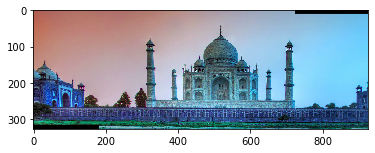

170
Calculated homography matrix 
 [[-2.10397658e-03  1.87313842e-06 -9.99985202e-01]
 [ 1.36599156e-07 -2.10353350e-03  4.03892921e-03]
 [ 8.39553029e-10  3.48882370e-09 -2.10513630e-03]]


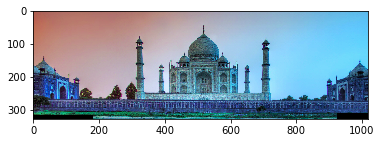

118
Calculated homography matrix 
 [[ 7.29382557e-03  3.75138540e-10 -3.64691099e-02]
 [-8.03255016e-09  7.29382846e-03  9.99254925e-01]
 [-3.59280270e-11  6.95338058e-12  7.29382963e-03]]


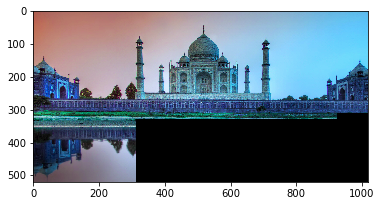

163
Calculated homography matrix 
 [[ 4.18231288e-03  1.22174752e-06  4.01455188e-01]
 [-2.39726871e-07  4.18472558e-03  9.15850009e-01]
 [-7.14254297e-10  7.10802152e-09  4.18210162e-03]]


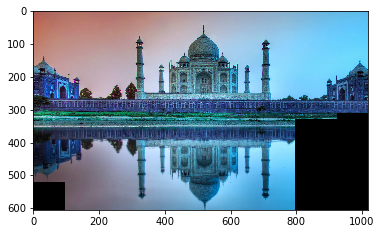

106
Calculated homography matrix 
 [[ 2.05615312e-03 -7.61006972e-07  8.66097460e-01]
 [-3.65730271e-07  2.05685780e-03  4.99862482e-01]
 [-1.08446042e-09  1.16763777e-09  2.05689475e-03]]


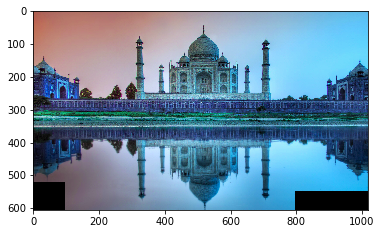

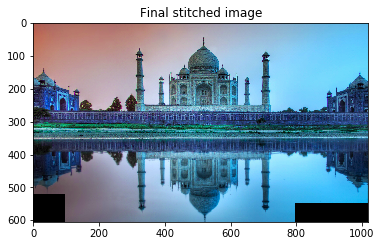

In [40]:
if __name__ == "__main__":
    
    seq_id = 2
    imageDir = './images/image_mosaicing/'
    stitchSequence(imageDir, seq_id)
    


    

## Q2)

### Part a)

Cross correlation matching of images

In [ ]:
def getMatchWindowLocation(patch, image, stride = 16):
    '''
    Gives the location of maximum correlation between patch and image
    '''
    
    heightPatch = patch.size[0]
    widthPatch = patch.size[1]
    correlationLocationMatrix = np.zeros(((image.shape[0] - patch.size[0]) / stride, (image.shape[1] - patch.size[1])/ stride)) 
    
    
    for i in range(0, image.shape[0] - patch.size[0], stride):
        for j in range(0, image.shape[1] - patch.size[1], stride):
            
            
            normalizedCorrelation = computeNormCorrelation(patch, image[i:i + heightPatch, j:j + widthPatch])
            correlationLocationMatrix[i / stride, j / stride] = normalizedCorrelation
            
            


def windowMatching(img1, img2, window_size = 32):
    '''
    Cross correlation window matching
    '''
    
    window = img1[(img1.shape[0]) / 2 : window_size, (img1.shape[1] / 2):window_size, :]
    
    